In [1]:
import cv2 
from matplotlib import pyplot as plt

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [3]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc2_train.csv", r"C:\Users\lucyc\Desktop\face_loc2")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc2_val.csv", r"C:\Users\lucyc\Desktop\face_loc2")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc2_test.csv", r"C:\Users\lucyc\Desktop\face_loc2")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lucyc\\Desktop\\face_loc2_train.csv'

In [ ]:
a, b, c = next(iter(val_loader))

In [ ]:
a.shape

torch.Size([128, 3, 12, 12])

In [ ]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [7]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [9]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 10, 3)  #12 -> 10 -> maxp -> 5
        self.conv2 = nn.Conv2d(10, 16, 3) #5 -> 3
        self.conv3 = nn.Conv2d(16, 32, 3) #3 -> 1

        self.face_det = nn.Conv2d(32, 2, 1) #1 -> 1
        self.bbox = nn.Conv2d(32, 4, 1) #1 -> 1
        self.landmark = nn.Conv2d(32, 10, 1) #1 -> 1

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #10
        x = F.max_pool2d(x, 2) #5
        x = F.relu(self.conv2(x)) #3
        x = F.relu(self.conv3(x)) #1

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        facedet = torch.flatten(facedet, 1)
        bbox = torch.flatten(bbox, 1)
        landmark = torch.flatten(landmark, 1)

        return facedet, bbox, landmark


In [10]:
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0.5 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [11]:
class PNetLossFace(nn.Module):
    def __init__(self):
        super(PNetLossFace, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype == "2":
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0 * bbox_loss + facedet_loss)

            elif ltype == "3":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        
        return loss_total

In [12]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [13]:
model.train()  # 设置模型为训练模式

train_x = []
train_loss_y = []

train_loss_acc = 0.
train_num = 0

for inputs in train_loader:
    
    img_tensor = inputs[0].to(device)
    label = inputs[1].to(device)
    ltypes = inputs[2]

    facedet, bbox, landmark = model(img_tensor)
    optimizer.zero_grad()  # 清除之前的梯度
    loss = criterion(facedet, bbox, landmark, label, ltypes)
    # 反向传播和优化
    loss.backward()  # 反向传播计算当前的梯度
    optimizer.step()  # 更新参数

    train_loss_acc += loss.item()
    train_num += 1

    train_x.append(train_num)
    train_loss_y.append(loss.item())
    
    print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset))
    

1 13.183084487915039 0.0659154224395752 128 178786
2 13.489697456359863 0.13336390972137452 256 178786
3 12.16739273071289 0.19420087337493896 384 178786
4 15.29731559753418 0.27068745136260985 512 178786
5 14.192448616027832 0.341649694442749 640 178786
6 14.135438919067383 0.41232688903808595 768 178786
7 15.864851951599121 0.4916511487960815 896 178786
8 12.457090377807617 0.5539366006851196 1024 178786
9 13.510858535766602 0.6214908933639527 1152 178786
10 17.160669326782227 0.7072942399978638 1280 178786
11 13.783679962158203 0.7762126398086547 1408 178786
12 12.987013816833496 0.8411477088928223 1536 178786
13 15.571935653686523 0.9190073871612549 1664 178786
14 14.413349151611328 0.9910741329193116 1792 178786
15 14.608684539794922 1.064117555618286 1920 178786
16 14.2760591506958 1.135497851371765 2048 178786
17 13.518083572387695 1.2030882692337037 2176 178786
18 14.676372528076172 1.2764701318740845 2304 178786
19 15.131386756896973 1.3521270656585693 2432 178786
20 15.138360

In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [14]:

criterion = PNetLoss()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 1.469389796257019 1.469389796257019 32 14898
2 1.893997073173523 1.681693434715271 64 14898
3 1.6151622533798218 1.6595163742701213 96 14898
4 1.2902228832244873 1.5671930015087128 128 14898
5 1.5681804418563843 1.5673904895782471 160 14898
6 1.522395372390747 1.5598913033803303 192 14898
7 1.5080171823501587 1.5524807146617345 224 14898
8 2.1542999744415283 1.6277081221342087 256 14898
9 1.7462776899337769 1.640882518556383 288 14898
10 1.7058799266815186 1.6473822593688965 320 14898
11 1.5856581926345825 1.641770980574868 352 14898
12 1.4621522426605225 1.6268027524153392 384 14898
13 1.7049996852874756 1.6328179010978112 416 14898
14 2.1870076656341553 1.6724028842789787 448 14898
15 1.680567741394043 1.6729472080866497 480 14898
16 1.5400887727737427 1.664643555879593 512 14898
17 1.4449437856674194 1.6517200399847591 544 14898
18 1.8475552797317505 1.6625997755262587 576 14898
19 2.0123579502105713 1.6810081005096436 608 14898
20 1.7301496267318726 1.683465176820755 640 14898
21

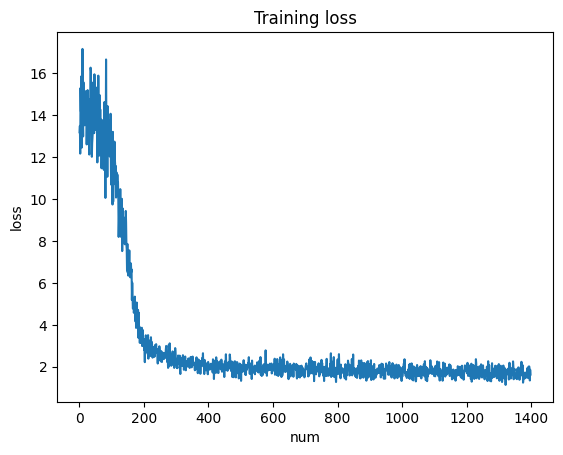

In [15]:
# draw loss curve
plt.plot(train_x, train_loss_y, label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [17]:
# 保存模型
torch.save(model, 'face_loc_p_nn.pth')

In [4]:
# load model
model_trained = torch.load('face_loc_p_3.pth')
model_trained.eval()  # 设置模型为评估/测试模式


AttributeError: Can't get attribute 'PNet' on <module '__main__'>

In [19]:
aa = iter(test_loader)

In [25]:

a, b, c = next(aa)

In [26]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"

In [ ]:
right = 0
total = 0
for i in range(32):

    visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    print(is_face(c[i]))

    face_det, bbox, landmark = model_trained(a[i].to(device))

    if face_det[0] - face_det[1] > 1.5:
        print("face")
        visualize_transformed_image(a[i],get_argsn(bbox),get_argsn(landmark))   
    else:
        print("not face")
        visualize_transformed_image(a[i],[0,0,0,0],None)
    
    if face_det[0] > face_det[1] and is_face(c[i]) == "face":
        right += 1
    if face_det[0] < face_det[1] and is_face(c[i]) == "not face":
        right += 1

    total += 1

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/128))

In [ ]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))

    model.eval() 
    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(train_dataset))

    print("Epoch [{}/{}], Loss: {:.2f}, Val_loss: {:.2f}".format(epoch+1, num_epochs, val_loss_acc/val_num, val_loss_acc/val_num))

    # draw loss curve
    plt.plot(train_x, train_loss_y, label='train')
    plt.xlabel('num')
    plt.ylabel('loss')
    plt.title('Training loss')
    plt.show()
    
    input("Press Enter to continue...")
